## TODO

Look how the stockfish metrics are deterministic

consider how many pieces are left, 

## Set Up Df

In [41]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

import chess
import chess.svg
from IPython.display import SVG, display

#import matplotlib.patches as patches

# faster way to visualize chess board from the reduced fen string
def draw_board(ReducedFen):
    piece_placement = ReducedFen
    fen = f"{piece_placement} w KQkq - 0 1"  # Aggiunge campi minimi validi

    board = chess.Board(fen)
    display(SVG(chess.svg.board(board)))


# Connessione al database SQLite
db_path = "chess_games.db"  # Sostituisci con il percorso corretto del tuo database
conn = sqlite3.connect(db_path)



In [4]:

query = "SELECT board_fen FROM moves;"
df = pd.read_sql_query(query, conn)

# Estrai i primi 3 campi della FEN
df['fen_prefix'] = df['board_fen'].str.split().str[:1].str.join(' ')


uniqueFenCount = df['board_fen'].nunique()
uniqueReducedFenCount = df['fen_prefix'].nunique()

print(f"Number of unique BoardState: {uniqueFenCount}")
print(f"Number of unique reducedBoardState: {uniqueReducedFenCount}")

Number of unique BoardState: 16785818
Number of unique reducedBoardState: 14759455


In [5]:
query_total_moves = "SELECT COUNT(*) AS total_moves FROM moves;"
total_moves = pd.read_sql_query(query_total_moves, conn).iloc[0, 0]
print(f"Number of moves: {total_moves}")


Number of moves: 18951733


In [6]:
query_move_vocab = "SELECT COUNT(DISTINCT move) AS move_vocab_size FROM moves;"
move_vocab_size = pd.read_sql_query(query_move_vocab, conn).iloc[0, 0]
print(f"moves vocabolary size: {move_vocab_size}")

moves vocabolary size: 1959


In [7]:
query_all_moves = "SELECT * FROM moves;"

# Caricare i dati in un DataFrame Pandas
moves_df = pd.read_sql_query(query_all_moves, conn)


# Visualizza informazioni sul DataFrame (tipi di dati, valori non nulli, ecc.)
print("\nInformazioni sul DataFrame 'moves_df':")
moves_df.info()

# 1. Estrai la parte della FEN relativa alla posizione dei pezzi
# La prima parte della stringa FEN, prima dello spazio, rappresenta la posizione dei pezzi.
moves_df['piece_placement_fen'] = moves_df['board_fen'].apply(lambda fen: fen.split(' ')[0])



Informazioni sul DataFrame 'moves_df':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18951733 entries, 0 to 18951732
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   id           int64 
 1   game_id      int64 
 2   move_number  int64 
 3   move         object
 4   board_fen    object
dtypes: int64(3), object(2)
memory usage: 723.0+ MB


Remove opening and the late game situation

In [ ]:
#if 'moves_df' in locals() and isinstance(moves_df, pd.DataFrame) and \
#'piece_placement_fen' in moves_df.columns and 'move_number' in moves_df.columns:

# Remove the opening part move_number >=30
#firstly was 30, but now more beacause all the most common moves are in the first 35/40 moves 
movesPostOpening = moves_df[moves_df['move_number'] >= 42].copy() 
# Remove the Late Game situation with like three piece on the board
movesNotLateGame = movesPostOpening[movesPostOpening['piece_placement_fen'].str.len() > 25].copy()


Extract the games information from the database and add them into our df

In [9]:
games_df = pd.read_sql_query("SELECT id, result, termination FROM games", conn)


games_df.rename(columns={'id': 'game_id'}, inplace=True)

#left join on game_id
moves_df = movesNotLateGame.merge(games_df, on='game_id', how='left')

## Analisys

In [48]:
query = "SELECT * FROM games;"
game = pd.read_sql_query(query, conn)

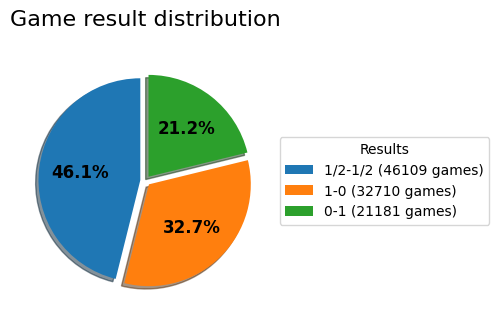

Result distribution upon  100000 :
  Risultato  Numero di partite  Percentuale
0   1/2-1/2              46109        46.11
1       1-0              32710        32.71
2       0-1              21181        21.18


In [ ]:
result_counts = game['result'].value_counts()
n_match=result_counts.sum()
# Crea il grafico a torta
plt.figure(figsize=(5, 5))
wedges, texts, autotexts = plt.pie(
    result_counts, 
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    shadow=True,
    explode=[0.05] * len(result_counts),  # Leggera esplosione di tutte le fette
    textprops={'fontsize': 12}
)

# Migliora l'aspetto dei testi percentuali
for autotext in autotexts:
    autotext.set_fontweight('bold')

# Aggiungi titolo
plt.title('Game result distribution', fontsize=16, pad=20)

# Aggiungi legenda con valori assoluti e percentuali
legend_labels = [f'{label} ({count} games)' for label, count in result_counts.items()]
plt.legend(wedges, legend_labels, title="Results", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Assicura che il grafico sia ben proporzionato con la legenda
plt.tight_layout()

# Mostra il grafico
plt.show()

# Stampa i risultati anche come tabella

print("Result distribution upon ",n_match,":")
result_percentage = result_counts / n_match * 100
result_df = pd.DataFrame({
    'Results': result_counts.index,
    'Number of matchs': result_counts.values,
    'Percentage': result_percentage.values.round(2)

})
print(result_df)

In [10]:
fen_counts_filtered = moves_df['piece_placement_fen'].value_counts() #count unique fen strings



unique_fenAndGame_pairs = moves_df.drop_duplicates(subset=['piece_placement_fen', 'game_id'])

# Conta quante volte ogni FEN appare in giochi unici
fenAndGame_counts_filtered = unique_fenAndGame_pairs['piece_placement_fen'].value_counts()


In [11]:
#just to reduce the number of rows to plot and to see the most common ones
fen_counts_filtered = fen_counts_filtered[fen_counts_filtered >5]
print(fen_counts_filtered.size)

fenAndGame_counts_filtered = fenAndGame_counts_filtered[fenAndGame_counts_filtered >3]
fenAndGame_counts_filtered.size

3604


3833

In [12]:
print("number of board considered:",fen_counts_filtered.sum())
print("number of BoardAndGames considered:",fenAndGame_counts_filtered.sum())


number of board considered: 27280
number of BoardAndGames considered: 20808


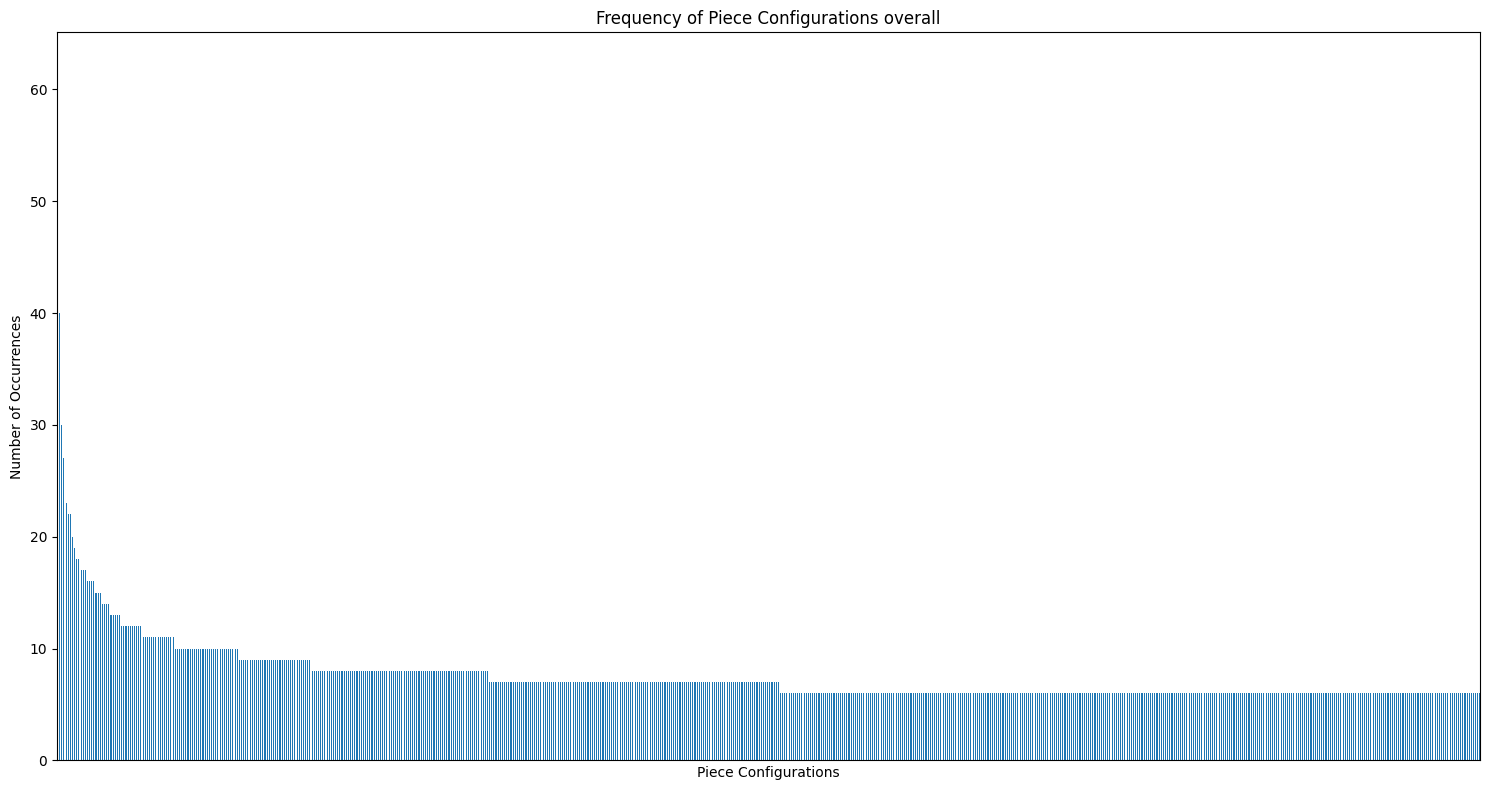

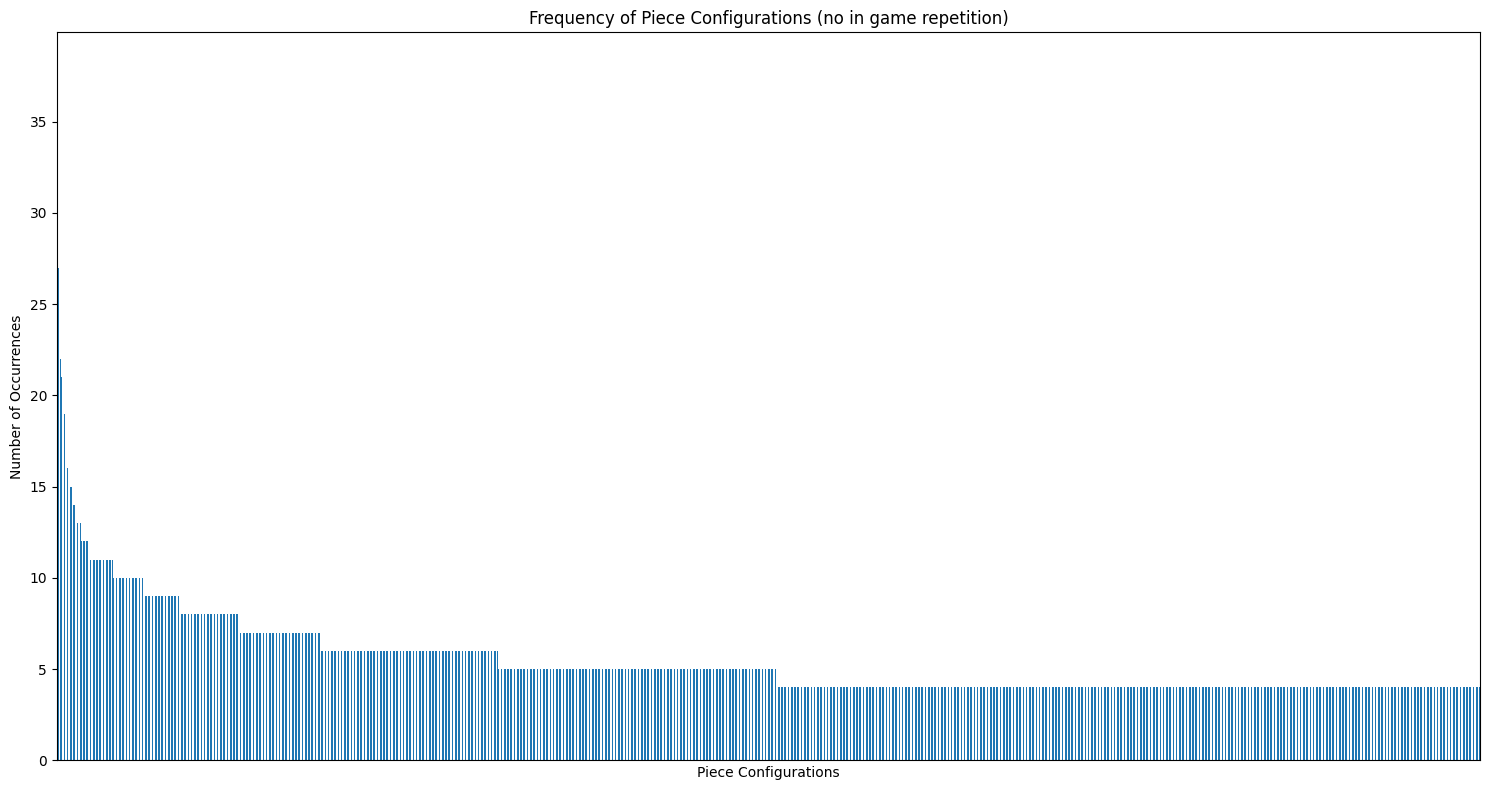

In [13]:
plt.figure(figsize=(15, 8))
fen_counts_filtered.plot(kind='bar')
plt.title('Frequency of Piece Configurations overall')
plt.xlabel('Piece Configurations')
plt.ylabel('Number of Occurrences')
plt.xticks([], [])  
plt.tight_layout()
plt.show()


plt.figure(figsize=(15, 8))
fenAndGame_counts_filtered.plot(kind='bar')
plt.title('Frequency of Piece Configurations (no in game repetition)')
plt.xlabel('Piece Configurations')
plt.ylabel('Number of Occurrences')
plt.xticks([], [])  
plt.tight_layout()
plt.show()

In [14]:
print(fen_counts_filtered.head(5))

fenAndGame_counts_filtered.head(5)


piece_placement_fen
7N/p1R1k1pp/5n2/1B2p3/4P3/1n1K4/r4PPP/8      62
7N/p3k1pp/2R2n2/1B2p3/4P3/1n1K4/r4PPP/8      62
6k1/B4p1p/2Np2p1/3P4/1p3P2/7P/1Q2n1PK/4q3    55
6k1/B4p1p/2Np2p1/3P4/1p3P2/6qP/1Q2n1P1/7K    44
6k1/B4p1p/2Np2p1/3P4/1p3P2/6qP/1Q2n1PK/8     44
Name: count, dtype: int64


piece_placement_fen
3n2k1/pb1rrpp1/1p1q3p/5R2/5Q2/P3PN1P/BP3KP1/2R5    38
2r5/p2R1kpp/8/8/1n2K3/1P6/P4PPP/8                  28
2r5/p4kpp/8/8/1n2K3/1P6/P2R1PPP/8                  28
1r4k1/p3ppbp/6p1/8/4p1b1/1P6/P1PK1PPP/4RB1R        27
1r4k1/p3ppbp/6p1/8/4p1b1/1PK5/P1P2PPP/4RB1R        27
Name: count, dtype: int64

In [15]:
#draw_board(fen_counts_filtered.index[0])

Brief check if all a fen appear only in one game

In [16]:
#top_16_fens = fen_counts_filtered.head(16).index.tolist()
#subset = movesNotLateGame[movesNotLateGame['piece_placement_fen'] == top_16_fens[14]].copy()

#subset.head(100)

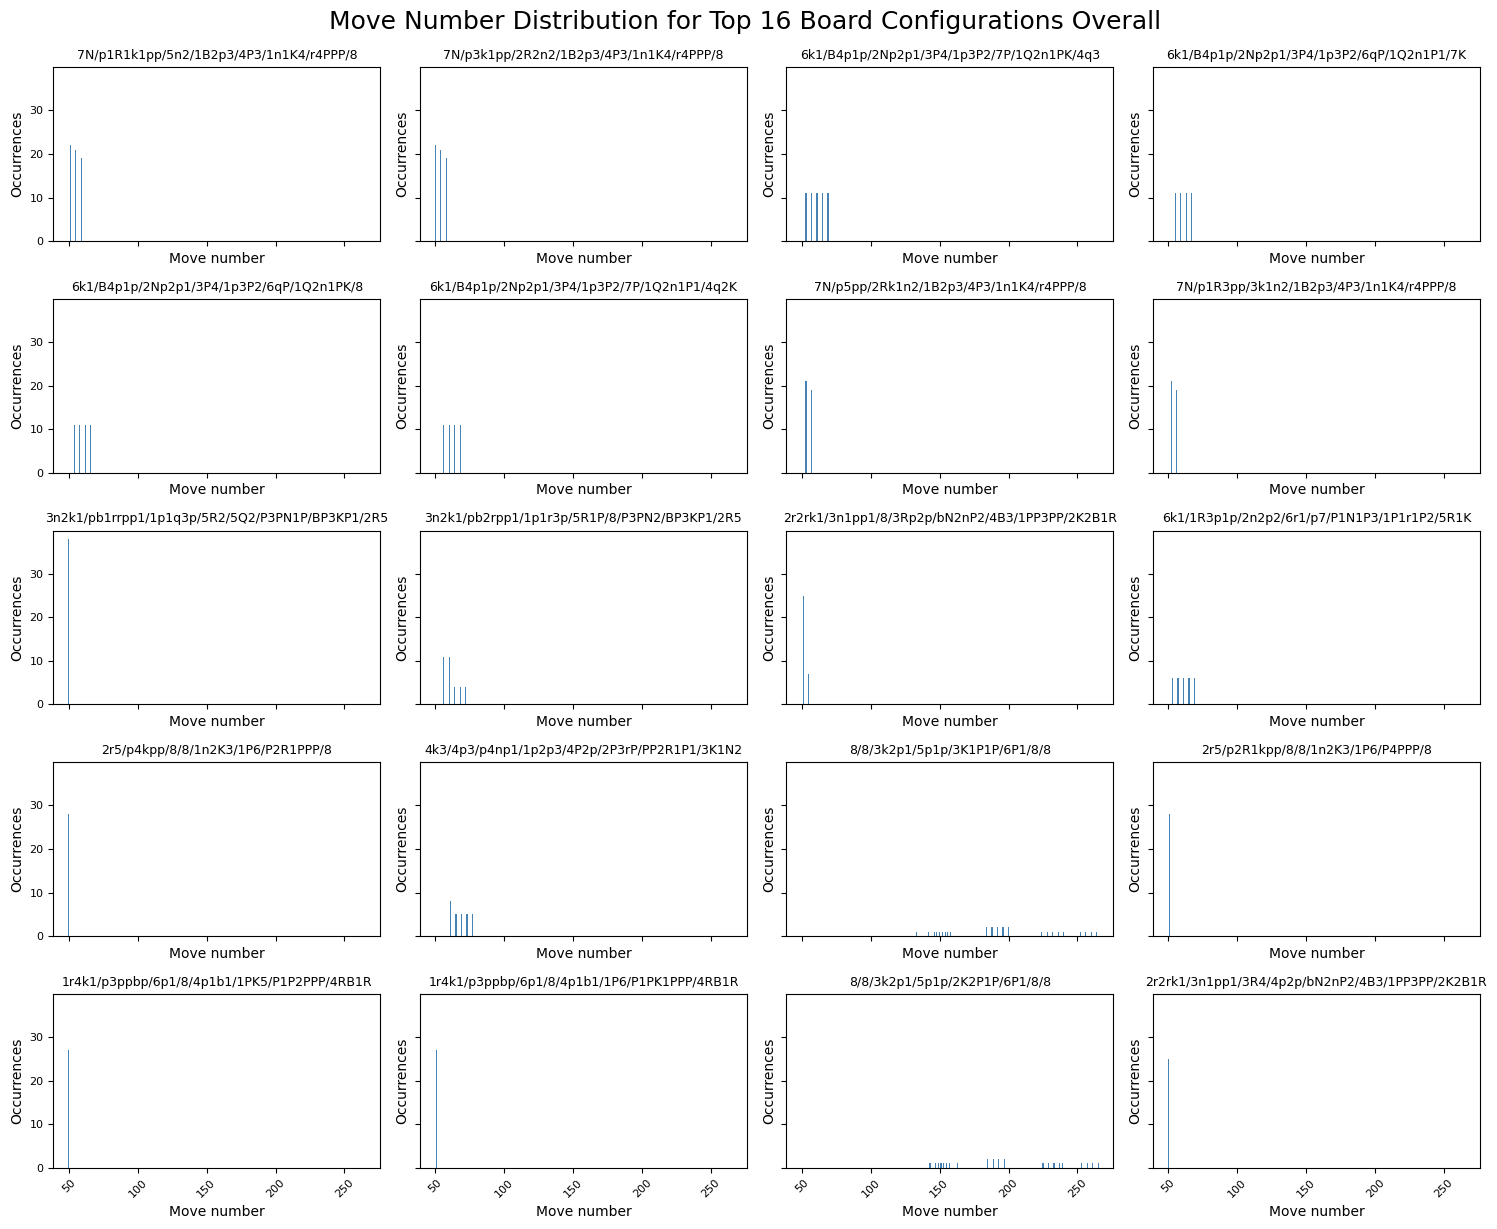

In [17]:
n=5  # Number of rows
m= 4  # Number of columns

top_fensOverall = fen_counts_filtered.head(n*m).index.tolist()

fig, axes = plt.subplots(n, m, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, fen in enumerate(top_fensOverall):
    subset = movesNotLateGame[movesNotLateGame['piece_placement_fen'] == fen]
    move_counts = subset['move_number'].value_counts().sort_index()
    
    axes[i].bar(move_counts.index, move_counts.values, color='steelblue')
    axes[i].set_title(fen, fontsize=9)  
    axes[i].set_xlabel('Move number')
    axes[i].set_ylabel('Occurrences')
    axes[i].tick_params(axis='x', labelrotation=45, labelsize=8)
    axes[i].tick_params(axis='both', labelsize=8)


plt.tight_layout()
plt.suptitle("Move Number Distribution for Top 16 Board Configurations Overall", fontsize=18, y=1.02)
plt.show()

######################################################################################################################################
top_fensAndGames = fenAndGame_counts_filtered.head(n*m).index.tolist()

### Repeated FEN distribution across the games

Function for FEN distribution

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

fixed_terminations = [
    "CHECKMATE", "STALEMATE", "INSUFFICIENT_MATERIAL", "SEVENTYFIVE_MOVES",
    "FIVEFOLD_REPETITION", "FIFTY_MOVES", "THREEFOLD_REPETITION",
    "VARIANT_WIN", "VARIANT_LOSS", "VARIANT_DRAW"
]

# Nuovi valori per l'asse x
new_result_categories = ["notATie", "tie"]

def plot_fen_outcomes(moves_df, selected_fen):
    # Crea un nuovo DataFrame contenente solo le informazioni necessarie
    filtered_data = []
    
    # Filtra i dati rilevanti
    fen_rows = moves_df[moves_df['piece_placement_fen'] == selected_fen]
    
    # Per ogni partita unica, estrai le informazioni
    for game_id in fen_rows['game_id'].unique():
        game_data = fen_rows[fen_rows['game_id'] == game_id].iloc[0]
        result = 'tie' if game_data['result'] == '1/2-1/2' else 'notATie'
        termination = game_data['termination']
        filtered_data.append({
            'result_category': result,
            'termination': termination
        })
    
    # Crea un nuovo DataFrame senza warning
    if filtered_data:
        new_df = pd.DataFrame(filtered_data)
        
        # Conta le combinazioni
        grouped = new_df.groupby(['result_category', 'termination']).size().reset_index(name='count')
    else:
        # Crea un DataFrame vuoto con le colonne corrette
        grouped = pd.DataFrame(columns=['result_category', 'termination', 'count'])

    # Crea una griglia completa di tutte le combinazioni
    all_combinations = pd.MultiIndex.from_product(
        [new_result_categories, fixed_terminations],
        names=['result_category', 'termination']
    ).to_frame(index=False)

    # Merge per avere zeri dove mancano dati
    merged = all_combinations.merge(grouped, how='left', on=['result_category', 'termination']).fillna(0)
    merged['count'] = merged['count'].astype(int)

    # Plot
    plt.figure(figsize=(12, 6))
    scatter = plt.scatter(
        merged['result_category'],
        merged['termination'],
        s=merged['count'] * 100, 
        alpha=0.6,
        color='skyblue',
        edgecolor='black'
    )
    
    # Aggiungi annotazioni dei conteggi per i punti visibili
    for i, row in merged.iterrows():
        if row['count'] > 0:
            plt.annotate(f"{int(row['count'])}", 
                        (row['result_category'], row['termination']),
                        xytext=(5, 0), 
                        textcoords='offset points')

    plt.title(f"Outcome distribution for FEN:\n{selected_fen}")
    plt.xlabel("Result")
    plt.ylabel("Termination")
    plt.xticks(new_result_categories)
    plt.yticks(fixed_terminations)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_multiple_fen_outcomes(m, n, moves_df, df_top_fen): 
    fig, axes = plt.subplots(m, n, figsize=(5*n, 3.5*m), constrained_layout=True)

    # Garantisce che axes sia un array 2D
    axes = axes.reshape((m, n))

    for i in range(m):
        for j in range(n):
            idx = i * n + j
            if idx >= len(df_top_fen):  # Verifica per evitare errori di indice
                continue

            fen = df_top_fen[idx]
            
            # Crea un nuovo DataFrame contenente solo le informazioni necessarie
            filtered_data = []
            
            # Filtra i dati rilevanti
            fen_rows = moves_df[moves_df['piece_placement_fen'] == fen]
            
            # Per ogni partita unica, estrai le informazioni
            for game_id in fen_rows['game_id'].unique():
                game_data = fen_rows[fen_rows['game_id'] == game_id].iloc[0]
                result = 'tie' if game_data['result'] == '1/2-1/2' else 'notATie'
                termination = game_data['termination']
                filtered_data.append({
                    'result_category': result,
                    'termination': termination
                })
            
            # Crea un nuovo DataFrame senza warning
            if filtered_data:
                new_df = pd.DataFrame(filtered_data)
                
                # Conta le combinazioni
                grouped = new_df.groupby(['result_category', 'termination']).size().reset_index(name='count')
            else:
                # Crea un DataFrame vuoto con le colonne corrette
                grouped = pd.DataFrame(columns=['result_category', 'termination', 'count'])

            # Crea una griglia completa di tutte le combinazioni
            all_combinations = pd.MultiIndex.from_product(
                [new_result_categories, fixed_terminations],
                names=['result_category', 'termination']
            ).to_frame(index=False)

            # Merge per avere zeri dove mancano dati
            merged = all_combinations.merge(grouped, how='left', on=['result_category', 'termination']).fillna(0)
            merged['count'] = merged['count'].astype(int)

            ax = axes[i, j]
            scatter = ax.scatter(
                merged['result_category'],
                merged['termination'],
                s=merged['count'] * 50,
                alpha=0.6,
                color='skyblue',
                edgecolor='black'
            )
            
            # Aggiungi annotazioni dei conteggi per i punti visibili
            for _, row in merged.iterrows():
                if row['count'] > 0:
                    ax.annotate(f"{int(row['count'])}", 
                              (row['result_category'], row['termination']),
                              xytext=(5, 0), 
                              textcoords='offset points',
                              fontsize=8)

            ax.set_title(f'FEN: {fen}', fontsize=10)
            ax.set_xticks(new_result_categories)
            ax.set_yticks(fixed_terminations)
            ax.set_xlabel("Result")
            ax.set_ylabel("Termination")
            ax.tick_params(axis='x', labelrotation=45)
            ax.grid(True, linestyle='--', alpha=0.4)

    plt.suptitle("Outcome Distributions for Top FENs", fontsize=16)
    plt.show()

In [ ]:
###codice senza il merging di 1-0 e 0-1 into notATie
stringa='''fixed_results = ["1-0", "0-1", "1/2-1/2"]
fixed_terminations = [
    "CHECKMATE", "STALEMATE", "INSUFFICIENT_MATERIAL", "SEVENTYFIVE_MOVES",
    "FIVEFOLD_REPETITION", "FIFTY_MOVES", "THREEFOLD_REPETITION",
    "VARIANT_WIN", "VARIANT_LOSS", "VARIANT_DRAW"
]

def plot_fen_outcomes(moves_df, selected_fen):
    # Filtra solo le righe con quella FEN
    fen_df = moves_df[moves_df['piece_placement_fen'] == selected_fen]
    
    # Rimuove duplicati di game_id per evitare conteggi doppi
    fen_df_unique = fen_df.drop_duplicates(subset='game_id')

    # Conta le combinazioni result + termination
    grouped = fen_df_unique.groupby(['result', 'termination']).size().reset_index(name='count')

    # Crea una griglia completa di tutte le combinazioni
    all_combinations = pd.MultiIndex.from_product(
        [fixed_results, fixed_terminations],
        names=['result', 'termination']
    ).to_frame(index=False)

    # Merge per avere zeri dove mancano dati
    merged = all_combinations.merge(grouped, how='left', on=['result', 'termination']).fillna(0)
    merged['count'] = merged['count'].astype(int)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.scatter(
        merged['result'],
        merged['termination'],
        s=merged['count'] * 100, 
        alpha=0.6
    )

    plt.title(f"Outcome distribution for FEN:\n{selected_fen}")
    plt.xlabel("Result")
    plt.ylabel("Termination")
    plt.xticks(fixed_results)
    plt.yticks(fixed_terminations)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#m number of rows, n number of columns
def plot_multiple_fen_outcomes(m, n, moves_df, df_top_fen): 
    total = m * n
    
    
    fig, axes = plt.subplots(m, n, figsize=(5*n, 3.5*m), constrained_layout=True)

    # Garantisce che axes sia un array 2D
    axes = axes.reshape((m, n))

    for i in range(m):
        for j in range(n):
            idx = i * n + j
        

            fen = df_top_fen[idx]
            fen_df = moves_df[moves_df['piece_placement_fen'] == fen]
            fen_df_unique = fen_df.drop_duplicates(subset='game_id')
            grouped = fen_df_unique.groupby(['result', 'termination']).size().reset_index(name='count')

            all_combinations = pd.MultiIndex.from_product(
                [fixed_results, fixed_terminations],
                names=['result', 'termination']
            ).to_frame(index=False)

            merged = all_combinations.merge(grouped, how='left', on=['result', 'termination']).fillna(0)
            merged['count'] = merged['count'].astype(int)

            ax = axes[i, j]
            scatter = ax.scatter(
                merged['result'],
                merged['termination'],
                s=merged['count'] * 50,
                alpha=0.6,
                color='skyblue',
                edgecolor='black'
            )

            ax.set_title(f'FEN: {fen}', fontsize=10)
            ax.set_xticks(fixed_results)
            ax.set_yticks(fixed_terminations)
            ax.set_xlabel("Result")
            ax.set_ylabel("Termination")
            ax.tick_params(axis='x', labelrotation=45)
            ax.grid(True, linestyle='--', alpha=0.4)

    plt.suptitle("Outcome Distributions for Top FENs", fontsize=16)
    plt.show()'''

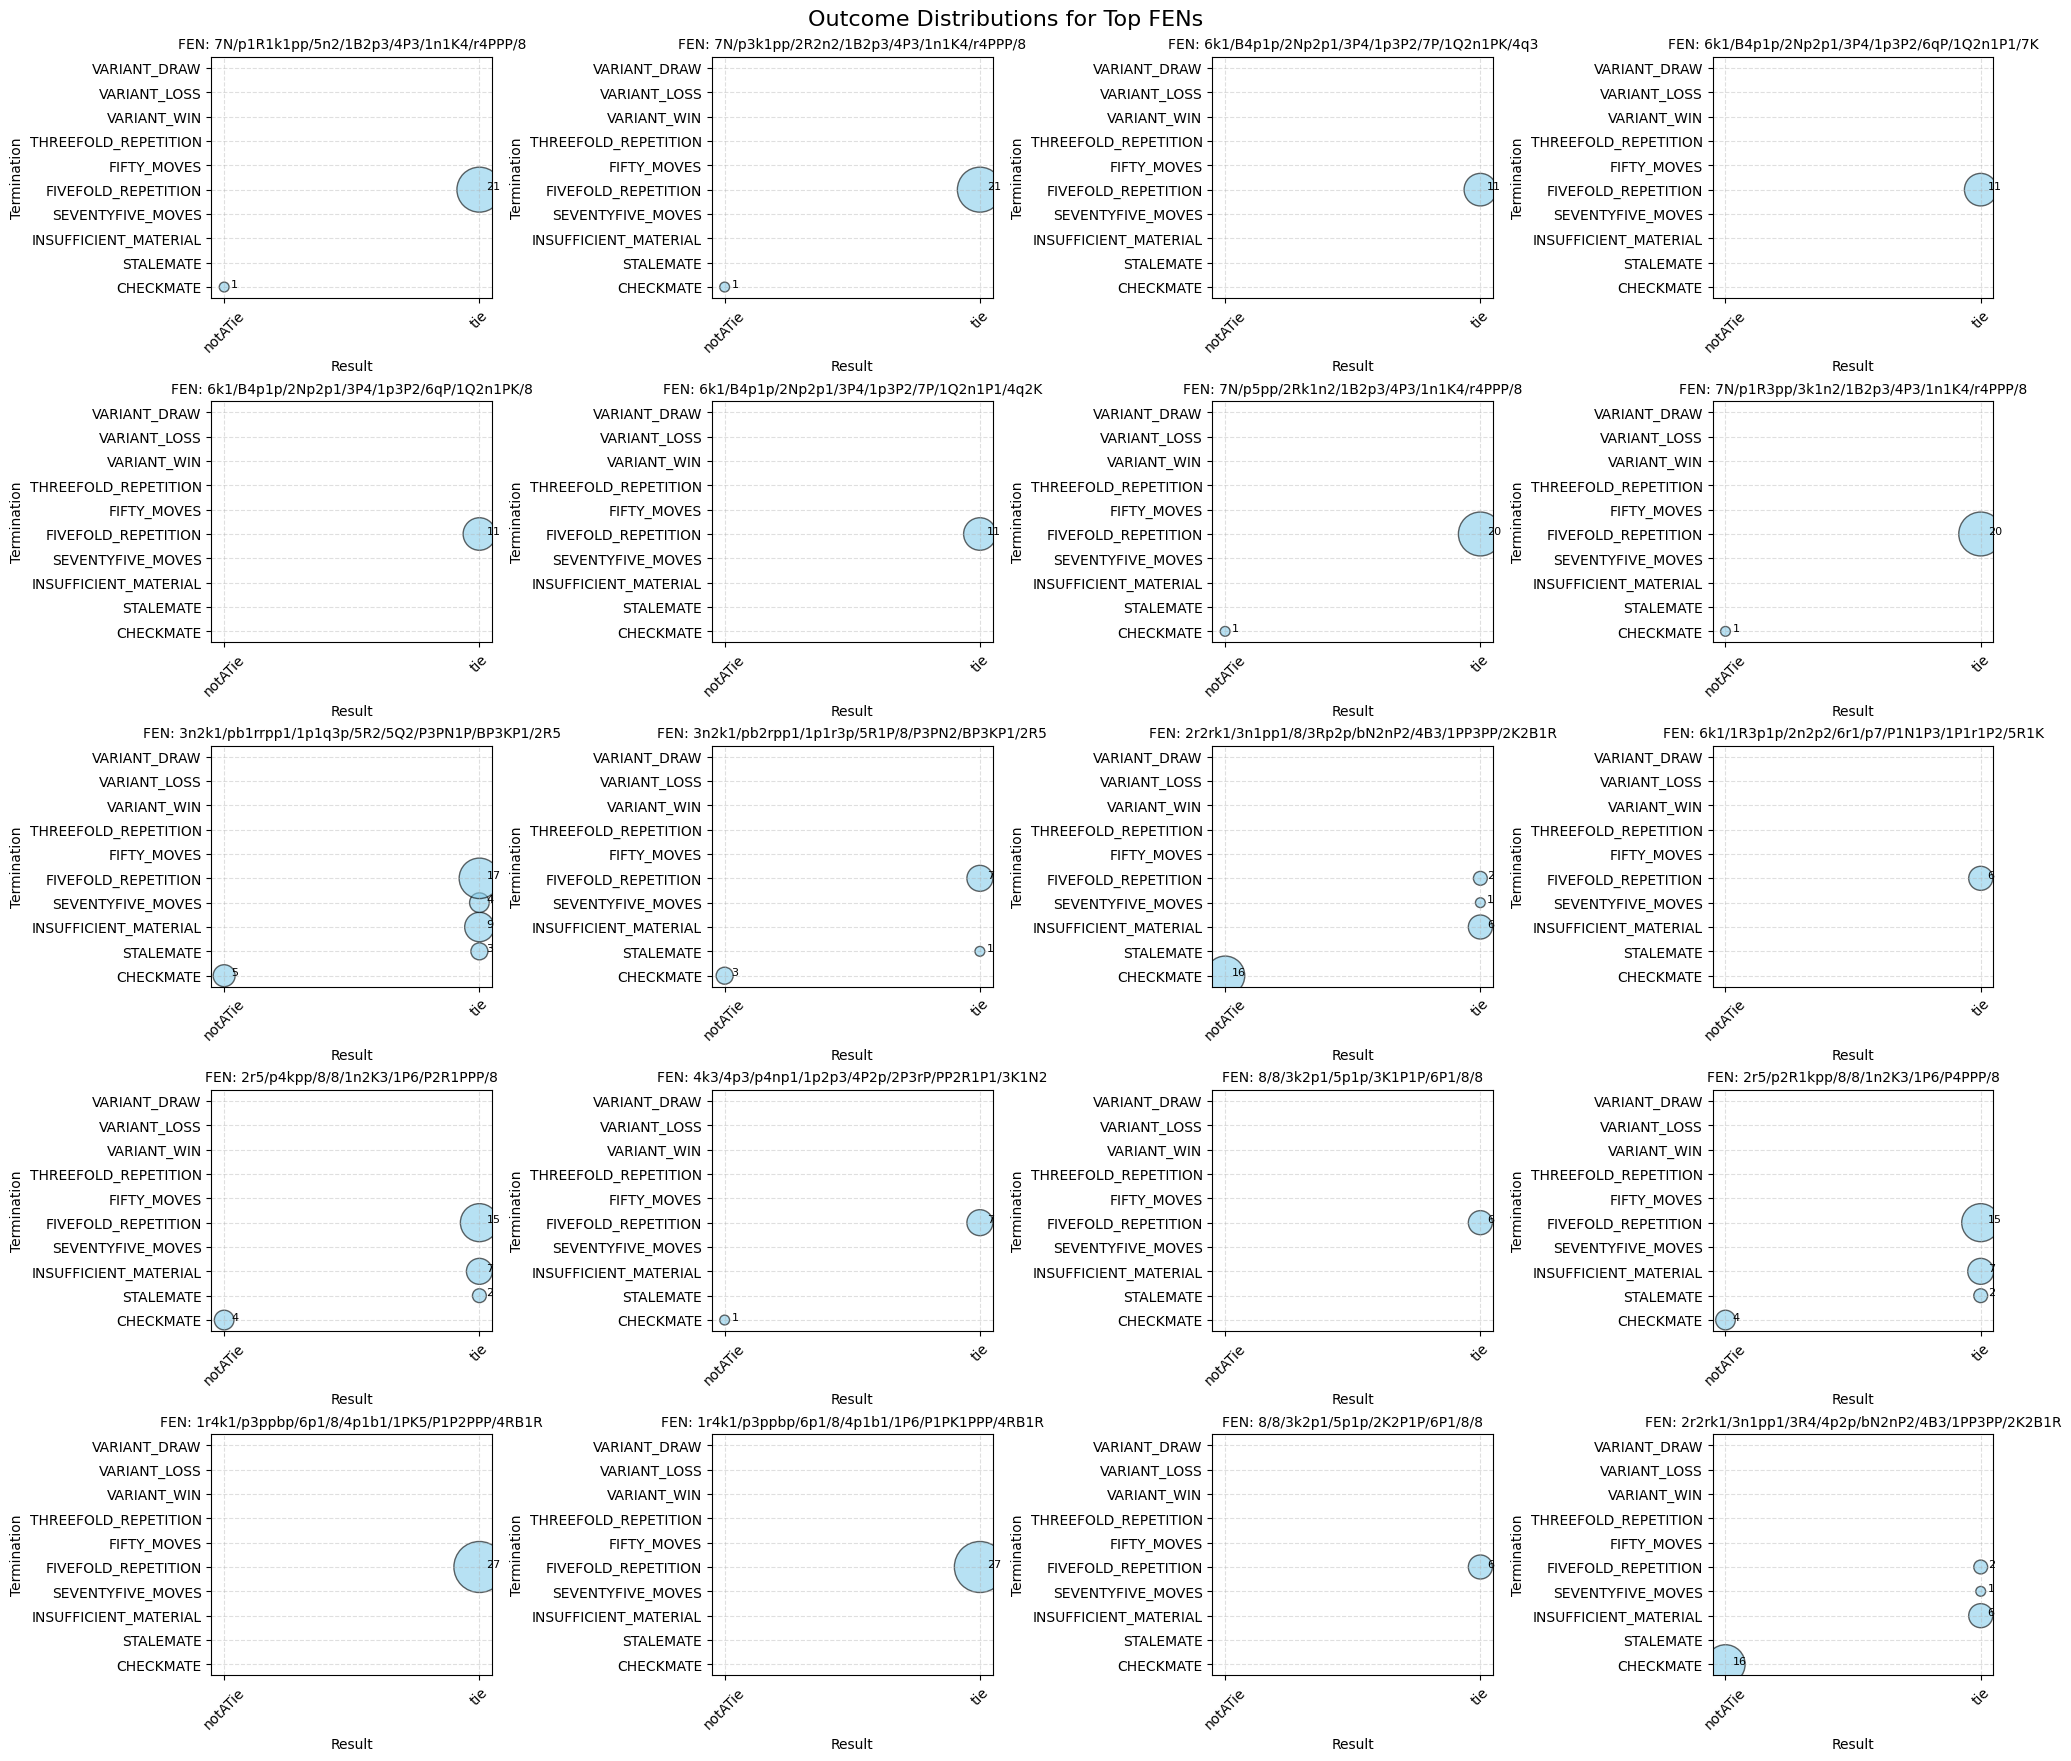

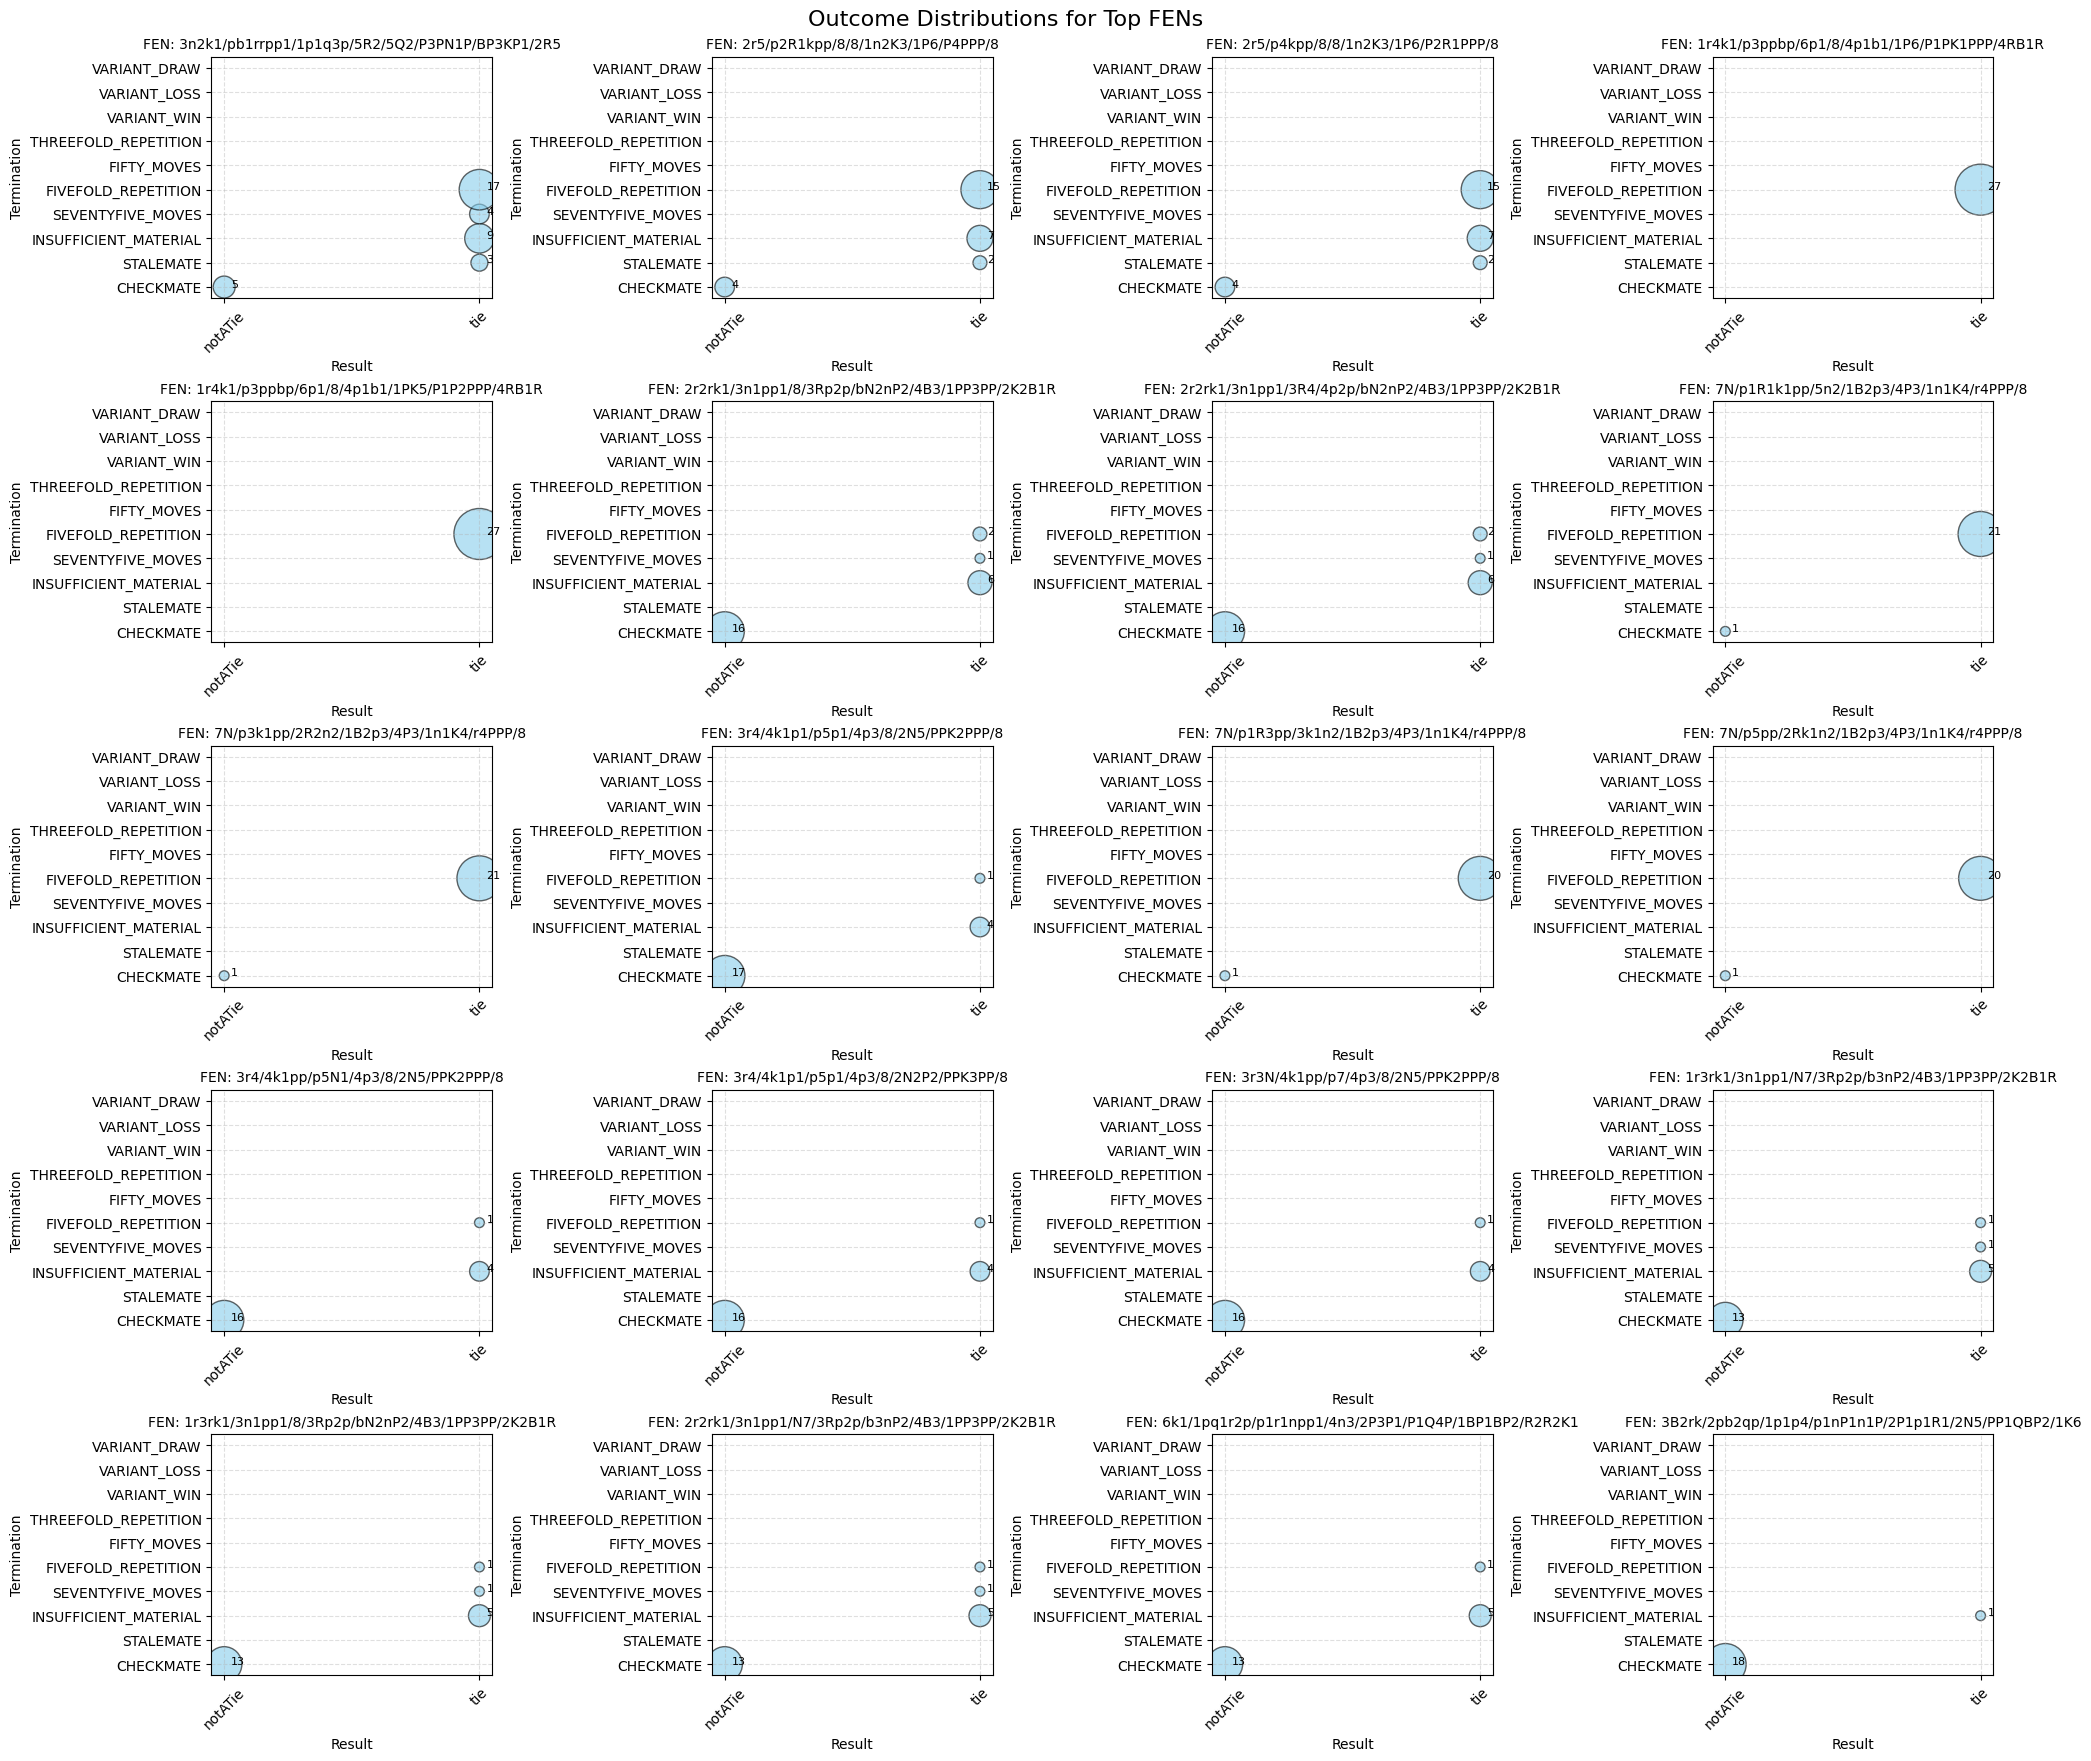

In [36]:
plot_multiple_fen_outcomes(n,m,moves_df,top_fensOverall)

plot_multiple_fen_outcomes(n,m,moves_df,top_fensAndGames)

If there's any need to have a zoom up a specific FEN distribution

In [40]:
#selected_fen = top_fensAndGames[0]
#plot_fen_outcomes(moves_df, selected_fen)

## Similarity(Dismissed)

In [ ]:
import chess
import numpy as np

# Convert a FEN string into an 8x8 matrix
def fen_to_matrix(fen):
    board_matrix = []
    for row in fen.split('/'):
        expanded_row = []
        for ch in row:
            if ch.isdigit():
                expanded_row.extend(['.'] * int(ch))
            else:
                expanded_row.append(ch)
        board_matrix.append(expanded_row)
    return np.array(board_matrix)

# Rotate a matrix 90 degrees clockwise n times
def rotate_board(mat, times=1):
    return np.rot90(mat, -times)

# Translate a matrix in x and y (wraps with empty squares)
def translate_board(mat, dx, dy):
    new_board = np.full((8, 8), '.', dtype=str)
    for y in range(8):
        for x in range(8):
            new_x = x + dx
            new_y = y + dy
            if 0 <= new_x < 8 and 0 <= new_y < 8:
                new_board[new_y][new_x] = mat[y][x]
    return new_board

# Calculate overlap score between two matrices, optionally filtered by a set of pieces
def calculate_overlap(mat1, mat2, filter_pieces=None):
    score = 0
    for y in range(8):
        for x in range(8):
            p1 = mat1[y][x]
            p2 = mat2[y][x]
            if filter_pieces:
                if p1 not in filter_pieces and p2 not in filter_pieces:
                    continue
            if p1 == p2 and p1 != '.':
                score += 1
    return score

# Main similarity function
def fen_similarity(fen1, fen2, filter_pieces=None):
    mat1 = fen_to_matrix(fen1.split()[0])
    mat2 = fen_to_matrix(fen2.split()[0])

    best_score = 0

    # Try all 4 rotations of the whole board
    for rot in range(4):
        rotated_mat2 = rotate_board(mat2, times=rot)
        
        # Try translations of mat2 (dx, dy from -2 to 2)
        for dx in range(-2, 3):
            for dy in range(-2, 3):
                translated_mat2 = translate_board(rotated_mat2, dx, dy)
                score = calculate_overlap(mat1, translated_mat2, filter_pieces=filter_pieces)
                best_score = max(best_score, score)

    return best_score / 32  # normalized to [0, 1] (max 32 same pieces)



from scipy.spatial import procrustes

def extract_piece_coords(fen, piece_symbol):
    board = chess.Board(fen + " w KQkq - 0 1")
    coords = []
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece and piece.symbol() == piece_symbol:
            row, col = divmod(square, 8)
            coords.append([row, col])
    return np.array(coords)

def procrustes_similarity(fen1, fen2, piece_symbol='n'):  # 'n' = cavallo nero
    coords1 = extract_piece_coords(fen1, piece_symbol)
    coords2 = extract_piece_coords(fen2, piece_symbol)

    if len(coords1) == 0 or len(coords2) == 0:
        return float('inf')  # totalmente dissimili

    # Bilancia le dimensioni
    min_len = min(len(coords1), len(coords2))
    coords1 = coords1[:min_len]
    coords2 = coords2[:min_len]

    mtx1, mtx2, disparity = procrustes(coords1, coords2)
    return disparity


##Piece-centric distance function

def manhattan_distance(pos1, pos2):
    x1, y1 = divmod(pos1, 8)
    x2, y2 = divmod(pos2, 8)
    return abs(x1 - x2) + abs(y1 - y2)

def piece_centric_distance(fen1, fen2):
    board1 = chess.Board(fen1 + " w KQkq - 0 1")
    board2 = chess.Board(fen2 + " w KQkq - 0 1")

    distance = 0
    for square in chess.SQUARES:
        piece1 = board1.piece_at(square)
        if piece1:
            # Cerca lo stesso pezzo nell'altra board
            found = False
            for sq2 in chess.SQUARES:
                piece2 = board2.piece_at(sq2)
                if piece2 == piece1:
                    distance += manhattan_distance(square, sq2)
                    board2.remove_piece_at(sq2)
                    found = True
                    break
            if not found:
                distance += 8  # penalità per pezzo mancante
    return distance

In [ ]:
fen1="rn2kbnr/ppp1pppp/3p4/4q3/2b5/3Q2P1/PPPP1PPP/RNB1KBNR"
fen2="rn2kbnr/ppp1pppp/3p4/7q/5b2/2P3Q1/PP1PPPPP/RNB1KBNR"
fen3="k7/p5P1/3qb3/1r6/5B2/b4R2/2Q5/5K2" 
fen4="1k6/1p5P/4qb2/2r5/6B1/1b4R1/3Q4/6K1" #traslation 1right of fen3


print(piece_centric_distance(fen3,fen4))

11


In [ ]:
#conn.close()

## Metrics on chess games and analysis documents on common metrics


#### Fragility score 
https://www.researchgate.net/publication/384630486_Fragility_of_Chess_positions_measure_universality_and_tipping_points
It captures the tension within a position and serves as a strong indicator of tipping points in a game.
In well-known games, maximum fragility often aligns with decisive moments marked by brilliant moves. Fragility typically peaks appear around move 15(human games), with pawns (≈60%) and knights (≈20%) frequently involved in high-tension positions.
The computation make use of interaction graph, but the code for it is not on github and has to be requested


#### Average Centipawn loss
https://medium.com/@enzo.leon/data-science-and-chess-centipawn-loss-elo-correlation-e06089efd8b8
Centipawn loss is a measure of how much a player’s position worsens after making a move. It is calculated as the difference between the evaluation of the initial position and the evaluation of the new position.
(Chess evaluation is a measure of a player’s position in a chess game. It is calculated by a chess engine and is expressed as a number, where a absolute value higher is a state where 1 of the player has an advantage)
Evaluation_Loss = Position_After_First_Move_Eval - Starting_Position_Eval
                = +0.3 - (-0.2)
                = +0.5
ACPL=sum(Evaluation_Loss)/n_moves
the lower the better the player
the complexity of the game and the skill of the enemy can greatly influence it


#### Average error
AE represents the average of evaluation differences, expressed in centipawns (1 centipawn = 1/100 of a pawn), between the moves actually played by a player and the optimal moves suggested by the engine. A lower AE indicates greater overall accuracy in the game.
It is less influenced than the ACPL.

#### Coincidence value
Not standard in chess but can represent how much a player play as the chess engine through the game
Coincidence Value = (Number of coinciding moves with engine's top choice) / (Total number of moves played)

